
WPC Frontal Data?!?!
=========

Plots Fronts from WPC text files.
https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/fronts/catalog.html

* Data kept on server for approx. 1 month every (roughly) 3 hours -> not every time...


#### Imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from metpy.plots import add_metpy_logo

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import patheffects

from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot

#### Define some text outline effects

In [22]:
outline_effect = [patheffects.withStroke(linewidth=3, foreground='black')]

#### Quick map function

In [1]:
def create_map():
    # Set up the map projection
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

    # Change the DPI of the resulting figure. Higher DPI drastically improves the
    # look of the text rendering.
    plt.rcParams['savefig.dpi'] = 255

    # Create the figure and an axes set to the projection.
    fig = plt.figure(figsize=(20, 10))
    add_metpy_logo(fig, 1100, 300, size='large')
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)

    # Set plot bounds
    ax.set_extent((-130, -65, 20, 65))
    #ax.set_extent((-108.5, -102, 38.5, 41.5))
    #ax.set_extent((W-1.5,E+1.5,S-1.5,N+1.5))
    return fig,ax

#### Code to Parse Lat/Lon Frontal/METAR data

In [2]:
def front_parse_latlon(latlon_code="0560149",print_on=True):
    '''Grab lat and lon from coded values from WPC frontal analysis data
    
    Arguments
    ---------
    code : string
        ***** required - 7 digit string *****
        * format in XXXYYYY, with:
        XXX : 3-digit latitude; with a period in front of last digit
            ex. 384 -> 38.4 -> 38.4 deg north
            ex. 045 -> 04.5 -> 4.5 deg north
            ex. 009 -> 00.9 -> 0.9 deg north
        YYYY : 4-digit longitude; with a period in front of last digit
            ex. 1147 -> 114.7 -> 114.7 deg west
            ex. 0979 -> 097.9 -> 97.9 deg west
            ex. 0035 -> 003.5 -> 3.5 deg west
            
    Returns
    -------
    lat : str
        converted latitude
    lon : str
        converted longitude
    '''
    if len(latlon_code) != 7:
        raise Exception(f"Wrong number of digits in coded lat/lon: {latlon_code}\n\n"+\
                        f"Coded lat/lon number of digits: {len(latlon_code)}\n"+\
                        
                       "\nPlease check data and ensure you are given coded lat/lon pairs with 7 digits.\n"+\
                    "\nsee docs\n")
    lat_raw = latlon_code[0:3]
    lon_raw = latlon_code[3:]
    if print_on == True:
        print("-----------------------------------------------------")
        print(f"raw latitude: {lat_raw}\nraw longitude: {lon_raw}\n")
    
    lat = f"{latlon_code[0:2]}.{latlon_code[2:3]}".strip("00")
    lon = f"{latlon_code[3:-1]}.{latlon_code[-1:]}".strip("00")
    if print_on == True:
        print(f"converted latitude (N): {float(lat)}\nconverted longitude (W): {float(lon)}\n")
    
    return lat,lon

In [3]:
front_parse_latlon(latlon_code="065049",print_on=True)

Exception: Wrong number of digits in coded lat/lon: 065049

Coded lat/lon number of digits: 6

Please check data and ensure you are given coded lat/lon pairs with 7 digits.

see docs


#### Parse lat/lons for fronts and/or max/min

In [4]:
def get_front_lat_lon(fronts_data,index):
    
    fronts_data = fronts_data.iloc[index][0].split()
    
    fronts = [front_parse_latlon(i,print_on=False) for i in fronts_data[1:]]
    
    lats_fronts = [float(i[0]) for i in fronts]
    # make the longitudes negative since they are in degrees west
    lons_fronts = [-float(i[1]) for i in fronts]
    return lats_fronts,lons_fronts

---

## Read in the WPC frontal analysis from text file

In [8]:
fronts_data = pd.read_fwf("/Users/chowdahead/Downloads/Fronts_highres_KWBC_20210311_2100.txt",
                          header=None)

In [9]:
# quick look at data
fronts_data.head(20)

,0
0,
1,913
2,ASUS02 KWBC 112100
3,CODSUS
4,CODED SURFACE FRONTAL POSITIONS
5,NWS WEATHER PREDICTION CENTER COLLEGE PARK MD
6,529 PM EST THU MAR 11 2021
7,VALID 031121Z
8,HIGHS 1025 4631058 1033 3470677 1033 3300726 1...
9,6881593 1026 4331023 1022 4621137 1026 4471227...


0


In [10]:
fronts_data.iloc[10][0].split()
# notice the data looks incomplete - 
# the last entry is a pressure but no associated lat/lon...

['LOWS',
 '1005',
 '2491029',
 '1004',
 '6231444',
 '1016',
 '5501319',
 '1008',
 '3411081',
 '1014',
 '3430986',
 '1012']

### Want to check if the data for the fronts/max data is seperated onto a new line...
* For this specific dataset, we know the data for the Lows is in 4 seperate rows; 10-13


In [11]:
# print 4 rows associated with low pressures
fronts_data.iloc[10:13][0]

10    LOWS 1005 2491029 1004 6231444 1016 5501319 10...
11    3371012 1017 3610943 993 5150802 1009 5190893 ...
12    6141614 1014 4071101 1014 3641177 1017 3401196...
Name: 0, dtype: object

#### Search rows first character to see if it is an interger or letter
* This will identify which rows need to be appended to the closet row that had a string name of front/max
* Note - hardcoded for this specific file, needs adjusting for general use

In [12]:
low_data = []
low_data.append(fronts_data.iloc[10][0])
if fronts_data.iloc[11][0][0].isdigit():
    low_data.append(fronts_data.iloc[11][0])

if fronts_data.iloc[12][0][0].isdigit():
    low_data.append(fronts_data.iloc[12][0])
    
if fronts_data.iloc[13][0][0].isdigit():
    low_data.append(fronts_data.iloc[13][0])

    

In [13]:
low_data

['LOWS 1005 2491029 1004 6231444 1016 5501319 1008 3411081 1014 3430986 1012',
 '3371012 1017 3610943 993 5150802 1009 5190893 1002 6601223 1012 3571140 1019',
 '6141614 1014 4071101 1014 3641177 1017 3401196 1000 6001467 1006 6920780 986',
 '6080395 994 5550405 995 7550615 994 7110548 992 6410512']

#### Join elements of list into single entry example
* this is what we want to use to combine all other low data into the low row values

In [14]:
separator = ', '
low_data = separator.join(low_data)
low_data

'LOWS 1005 2491029 1004 6231444 1016 5501319 1008 3411081 1014 3430986 1012, 3371012 1017 3610943 993 5150802 1009 5190893 1002 6601223 1012 3571140 1019, 6141614 1014 4071101 1014 3641177 1017 3401196 1000 6001467 1006 6920780 986, 6080395 994 5550405 995 7550615 994 7110548 992 6410512'

In [15]:
low_data = low_data.replace(",","")
# no more commas - final product
# clean dataset, easy for manipulation
low_data

'LOWS 1005 2491029 1004 6231444 1016 5501319 1008 3411081 1014 3430986 1012 3371012 1017 3610943 993 5150802 1009 5190893 1002 6601223 1012 3571140 1019 6141614 1014 4071101 1014 3641177 1017 3401196 1000 6001467 1006 6920780 986 6080395 994 5550405 995 7550615 994 7110548 992 6410512'

### Make a pairing for the Low/High and its raw latlon code

In [16]:
low_values = fronts_data.iloc[10][0].split()[1::2][:-1] 
# upto last b/c extra extra pressure value at end of row (not complete set of lows data)
low_values

['1005', '1004', '1016', '1008', '1014']

In [17]:
lows_points = fronts_data.iloc[10][0].split()[2::2]
lows_points

['2491029', '6231444', '5501319', '3411081', '3430986']

In [18]:
low_latlon_pairs = [front_parse_latlon(i,print_on=False) for i in lows_points]

### Make list for lat/lons for all the Lows

In [19]:
lats_lows = [float(i[0]) for i in low_latlon_pairs]
lats_lows

[24.9, 62.3, 55.0, 34.1, 34.3]

In [20]:
# make the longitudes negative since they are in degrees west
lons_lows = [-float(i[1]) for i in low_latlon_pairs]
lons_lows

[-102.9, -144.4, -131.9, -108.1, -98.6]

### Plot the Lows

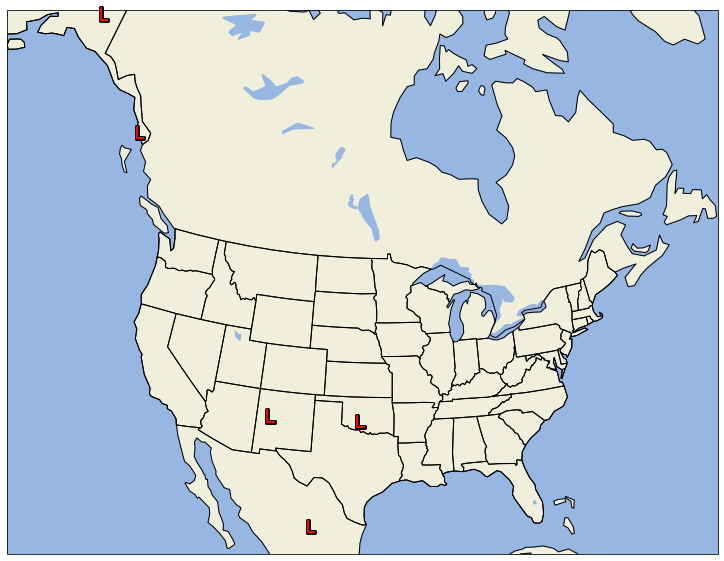

In [23]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
plt.show()

---

## Highs

#### Again, this is with the assumption we know which rows the High pressures occupy
* specific for this dataset

In [24]:
high_data = []
for i in range(8,10):

    if fronts_data.iloc[i][0][0].isalpha():
        high_data.append(fronts_data.iloc[i][0])
    if fronts_data.iloc[i][0][0].isdigit():
        high_data.append(fronts_data.iloc[i][0])
        
separator = ', '
high_data = separator.join(high_data)
high_data = high_data.replace(",","")

In [25]:
high_data

'HIGHS 1025 4631058 1033 3470677 1033 3300726 1027 4981055 1020 5941075 1027 6881593 1026 4331023 1022 4621137 1026 4471227 1025 5051198 1017 5660641'

In [26]:
high_latlon_pairs = [front_parse_latlon(i,print_on=False) for i in high_data.split()[2::2]]

In [27]:
high_latlon_pairs

[('46.3', '105.8'),
 ('34.7', '67.7'),
 ('33.', '72.6'),
 ('49.8', '105.5'),
 ('59.4', '107.5'),
 ('68.8', '159.3'),
 ('43.3', '102.3'),
 ('46.2', '113.7'),
 ('44.7', '122.7'),
 ('50.5', '119.8'),
 ('56.6', '64.1')]

#### Make list for lat/lons for all the Highs

In [28]:
lats_highs = [float(i[0]) for i in high_latlon_pairs]
lats_highs

[46.3, 34.7, 33.0, 49.8, 59.4, 68.8, 43.3, 46.2, 44.7, 50.5, 56.6]

In [29]:
# make the longitudes negative since they are in degrees west
lons_highs = [-float(i[1]) for i in high_latlon_pairs]
lons_highs

[-105.8,
 -67.7,
 -72.6,
 -105.5,
 -107.5,
 -159.3,
 -102.3,
 -113.7,
 -122.7,
 -119.8,
 -64.1]

#### Plot the Highs and Lows

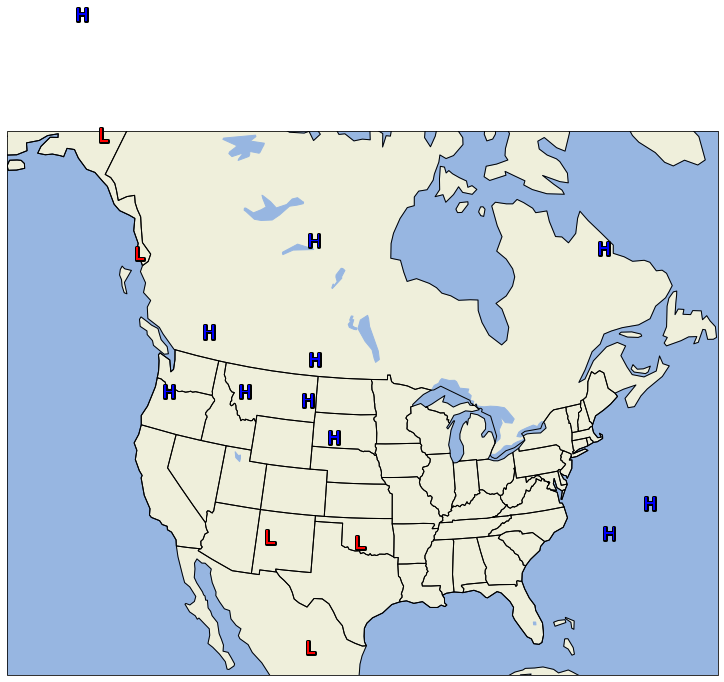

In [30]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
plt.show()

---

## Cold Fronts

In [64]:
fronts_data.shape[0]

150

#### Search through earch row to see if the first four characters are "COLD"
* place them in a list
    * for now, will probably be added to pandas dataframe instead eventually

In [234]:
cold_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:4] == "COLD"]
cold_index

[20, 32, 33, 35, 38, 54, 60, 96, 108, 109, 111, 114, 122]

#### Look at the data related to the 5th index of the cold front set (cold_index)

In [236]:
fronts_data.iloc[i][0][0:4]

'COLD'

In [253]:
# second set of Lows range : fronts_data.iloc[86:90]
fronts_data.iloc[86:91]

,0
86,LOWS 1005 2301036 1007 6110797 1023 4770845 10...
87,3501149 1001 3741038 1003 4151056 1006 4291105...
88,5700600 1006 6390742 1009 7321413 1004 7891130...
89,7310740 1007 7330674 1005 6940789
90,TROF 2800824 2490836 2070836


In [248]:
front_str = "LOWS"
fronts_index = [i for i in range(fronts_data.shape[0]) if front_str in fronts_data.iloc[i][0]]
fronts_index

[10, 86]

In [ ]:
fronts_data.iloc[fronts_index][0].split()

In [233]:
# cold_index[4] : 38 -> row number in the dataframe
cold_data = fronts_data.iloc[cold_index[4]][0].split()
cold_data

['COLD',
 '5750589',
 '5630581',
 '5450585',
 '5310595',
 '5080615',
 '4760635',
 '4490666',
 '4140707',
 '3910734']

In [212]:
cold_latlon_pairs = [front_parse_latlon(i,print_on=False) for i in cold_data[1:]]
cold_latlon_pairs

[('57.5', '58.9'),
 ('56.3', '58.1'),
 ('54.5', '58.5'),
 ('53.1', '59.5'),
 ('50.8', '61.5'),
 ('47.6', '63.5'),
 ('44.9', '66.6'),
 ('41.4', '70.7'),
 ('39.1', '73.4')]

#### Make list for lat/lons for all the Cold Fronts

In [213]:
lats_cold = [float(i[0]) for i in cold_latlon_pairs]
lats_cold

[57.5, 56.3, 54.5, 53.1, 50.8, 47.6, 44.9, 41.4, 39.1]

In [214]:
# make the longitudes negative since they are in degrees west
lons_cold = [-float(i[1]) for i in cold_latlon_pairs]
lons_cold

[-58.9, -58.1, -58.5, -59.5, -61.5, -63.5, -66.6, -70.7, -73.4]

#### Plot the Highs, Lows, and Cold Fronts

In [232]:
for i in cold_index:  
    lats_cold,lons_cold = get_front_lat_lon(fronts_data,i)
    print(lats_cold,lons_cold)

[30.3, 27.3, 24.8, 23.6, 23.8] [-88.0, -89.6, -92.3, -96.3, -99.0]
[37.4, 37.9, 38.6, 39.4, 40.2, 40.7] [-103.8, -104.7, -105.0, -105.0, -105.5, -105.5]
[41.5, 41.7, 41.9, 41.9, 42.1, 42.6] [-105.7, -106.3, -107.3, -108.4, -109.2, -109.8]
[42.9, 41.6, 40.7, 40.6, 41.2, 41.7, 42.2, 42.7, 43.8] [-110.5, -110.5, -111.6, -113.3, -115.5, -117.8, -120.0, -121.5, -123.1]
[57.5, 56.3, 54.5, 53.1, 50.8, 47.6, 44.9, 41.4, 39.1] [-58.9, -58.1, -58.5, -59.5, -61.5, -63.5, -66.6, -70.7, -73.4]
[73.2, 71.9, 71.2, 70.0, 69.1] [-141.5, -150.7, -156.3, -164.2, -170.6]
[44.5, 42.0, 40.0, 38.3] [-66.9, -69.8, -72.4, -75.2]
[30.7, 29.5, 27.3, 24.8, 23.7, 23.2, 23.7] [-88.1, -88.3, -89.6, -92.3, -95.3, -97.8, -99.1]
[37.4, 37.9, 38.6, 39.4, 40.2, 40.7] [-103.8, -104.7, -105.0, -105.0, -105.5, -105.5]
[41.5, 41.7, 41.9, 41.9, 42.1, 42.6] [-105.7, -106.3, -107.3, -108.4, -109.2, -109.8]
[42.9, 41.6, 40.7, 40.6, 41.2, 41.7, 42.2, 42.7, 43.8] [-110.5, -110.5, -111.6, -113.3, -115.5, -117.8, -120.0, -121.5, -12

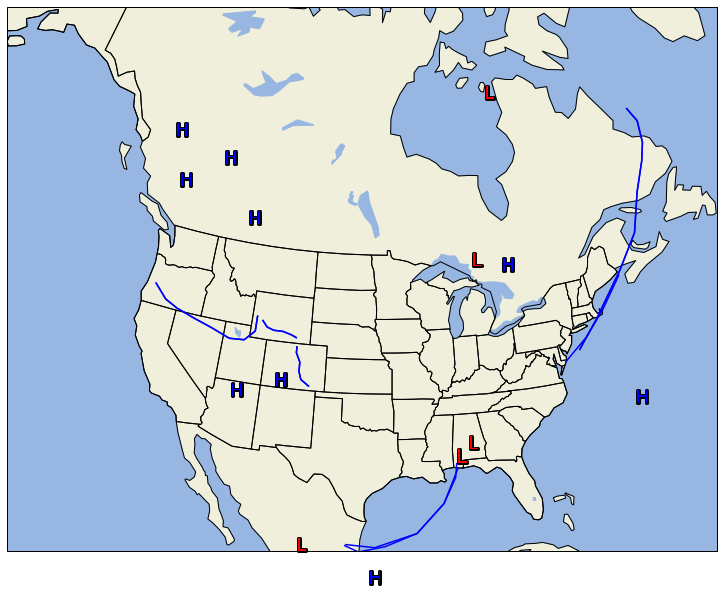

In [215]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in cold_index:  
    lats_cold,lons_cold = get_cold_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
plt.show()

---

## Warm Fronts

In [85]:
warm_index = []
for i in range(fronts_data.shape[0]):
    if fronts_data.iloc[i][0][0:4] == "WARM":
        print(i," ",fronts_data.iloc[i][0][0:4])
        warm_index.append(i)

67   WARM
69   WARM
119   WARM
143   WARM


In [218]:
warm_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:4] == "WARM"]

#### Plot the Highs, Lows, Cold and Warm Fronts

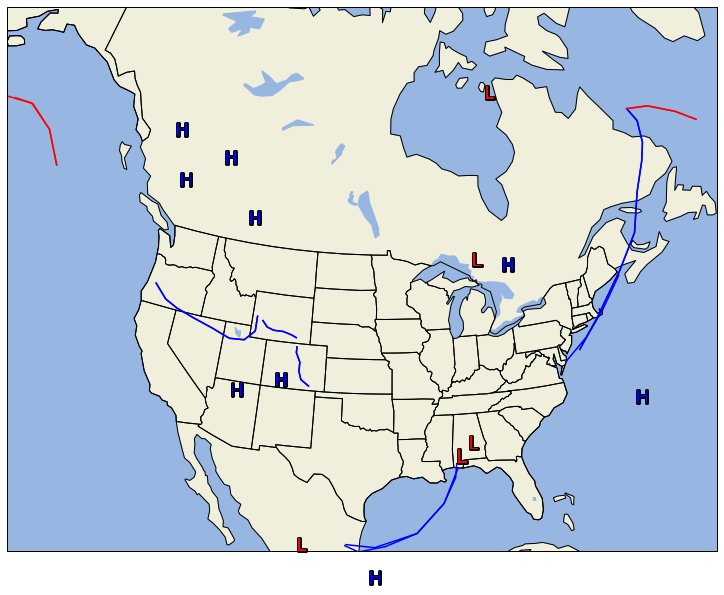

In [219]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in cold_index:  
    lats_cold,lons_cold = get_cold_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
plt.show()

---

## Stationary Fronts

In [91]:
stnry_index = []
for i in range(fronts_data.shape[0]):
    if fronts_data.iloc[i][0][0:5] == "STNRY":
        print(i," ",fronts_data.iloc[i][0][0:4])
        stnry_index.append(i)

21   STNR
25   STNR
26   STNR
27   STNR
29   STNR
30   STNR
31   STNR
34   STNR
37   STNR
52   STNR
59   STNR
65   STNR
71   STNR
97   STNR
101   STNR
103   STNR
105   STNR
106   STNR
107   STNR
110   STNR
113   STNR
131   STNR
136   STNR
141   STNR
145   STNR


In [220]:
stnry_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:5] == "STNRY"]

#### Plot the Highs, Lows, Cold, Warm, and Stationary Fronts

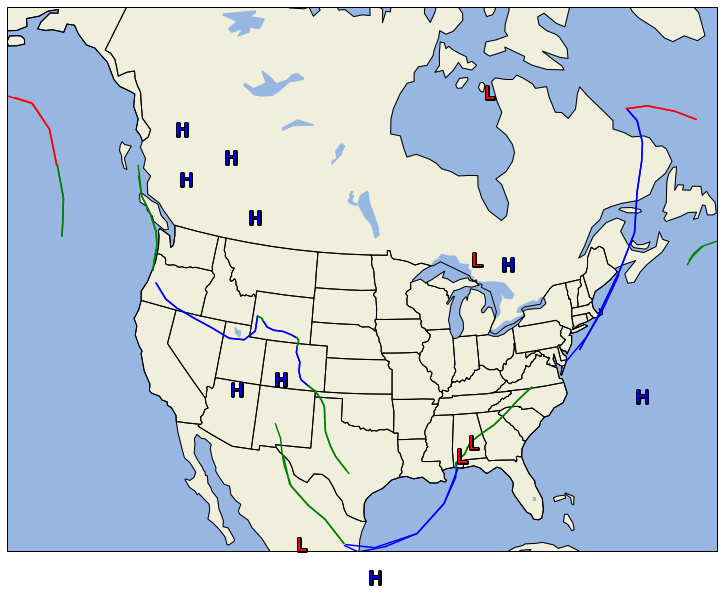

In [222]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in cold_index:  
    lats_cold,lons_cold = get_cold_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
plt.show()

---

## Occluded Fronts

In [96]:
occ_index = []
for i in range(fronts_data.shape[0]):
    if fronts_data.iloc[i][0][0:5] == "OCFNT":
        print(i," ",fronts_data.iloc[i][0][0:4])
        occ_index.append(i)

66   OCFN
68   OCFN
142   OCFN
144   OCFN


In [223]:
occ_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:5] == "OCFNT"]

#### Plot the Highs, Lows, Cold, Warm, Stationary, and Occluded Fronts

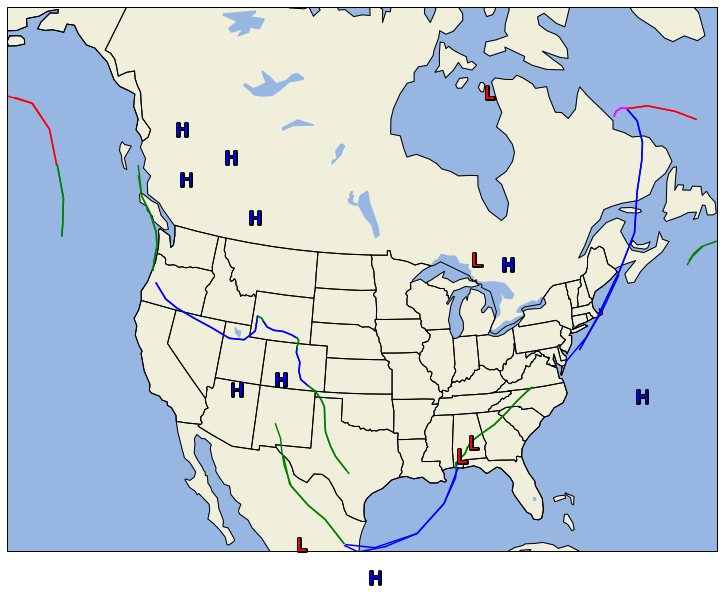

In [224]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in cold_index:  
    lats_cold,lons_cold = get_cold_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
for i in occ_index:  
    lats_occ,lons_occ = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_occ, lats_occ, color='magenta', 
         transform=ccrs.PlateCarree())
plt.show()

---

## TROFs

In [99]:
trof_index = []
for i in range(fronts_data.shape[0]):
    if fronts_data.iloc[i][0][0:4] == "TROF":
        print(i," ",fronts_data.iloc[i][0][0:4])
        trof_index.append(i)

14   TROF
15   TROF
16   TROF
17   TROF
18   TROF
19   TROF
22   TROF
23   TROF
24   TROF
28   TROF
40   TROF
41   TROF
42   TROF
43   TROF
44   TROF
45   TROF
46   TROF
47   TROF
48   TROF
49   TROF
51   TROF
53   TROF
55   TROF
56   TROF
57   TROF
58   TROF
61   TROF
62   TROF
63   TROF
64   TROF
70   TROF
72   TROF
73   TROF
74   TROF
90   TROF
91   TROF
92   TROF
93   TROF
94   TROF
95   TROF
98   TROF
99   TROF
100   TROF
102   TROF
104   TROF
116   TROF
117   TROF
118   TROF
120   TROF
121   TROF
123   TROF
124   TROF
125   TROF
126   TROF
127   TROF
128   TROF
130   TROF
132   TROF
133   TROF
134   TROF
135   TROF
137   TROF
138   TROF
139   TROF
140   TROF
146   TROF
147   TROF


In [225]:
trof_index = [i for i in range(fronts_data.shape[0]) if fronts_data.iloc[i][0][0:4] == "TROF"]

#### Plot the Highs, Lows, Cold, Warm, Stationary, Occluded Fronts and Trofs

NameError: name 'cold_index' is not defined

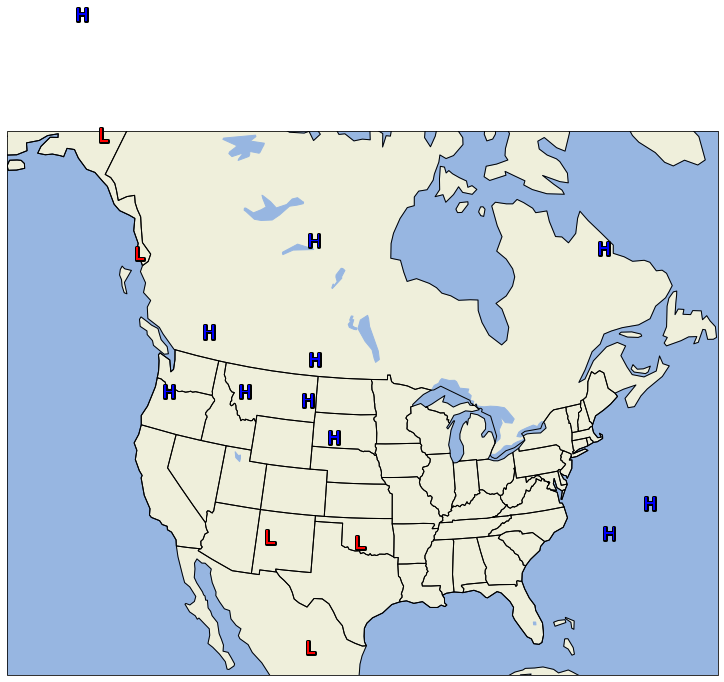

In [31]:
fig,ax = create_map()

for i in range(len(lons_lows)):
    plt.text(lons_lows[i], lats_lows[i], color='red',s="L" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in range(len(lons_highs)):
    plt.text(lons_highs[i], lats_highs[i], color='blue',s="H" ,fontsize=18,
         transform=ccrs.PlateCarree(),path_effects=outline_effect)
for i in cold_index:  
    lats_cold,lons_cold = get_cold_front_lat_lon(fronts_data,i)
    plt.plot(lons_cold, lats_cold, color='blue', 
         transform=ccrs.PlateCarree())
for i in warm_index:  
    lats_warm,lons_warm = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_warm, lats_warm, color='red', 
         transform=ccrs.PlateCarree())
for i in stnry_index:  
    lats_stnry,lons_stnry = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_stnry, lats_stnry, color='green', 
         transform=ccrs.PlateCarree())
for i in occ_index:  
    lats_occ,lons_occ = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_occ, lats_occ, color='magenta', 
         transform=ccrs.PlateCarree())
for i in trof_index:  
    lats_trof,lons_trof = get_front_lat_lon(fronts_data,i)
    plt.plot(lons_trof, lats_trof, color='orange',linestyle="--", 
         transform=ccrs.PlateCarree())
plt.show()

---

#### <center>End of Turorial</center>

---

In [ ]:
low_data = []
low_data.append(fronts_data.iloc[10][0])
if fronts_data.iloc[11][0][0].isdigit():
    low_data.append(fronts_data.iloc[11][0])

if fronts_data.iloc[12][0][0].isdigit():
    low_data.append(fronts_data.iloc[12][0])
    
if fronts_data.iloc[13][0][0].isdigit():
    low_data.append(fronts_data.iloc[13][0])

In [255]:
low_data = []
low_data.append(fronts_data.iloc[86][0])
for i in range(87,91):
    if fronts_data.iloc[i][0][0].isdigit():
        low_data.append(fronts_data.iloc[i][0])

#if fronts_data.iloc[12][0][0].isdigit():
#    low_data.append(fronts_data.iloc[12][0])
    
#if fronts_data.iloc[13][0][0].isdigit():
#    low_data.append(fronts_data.iloc[13][0])